## Enable rendering OpenAI Gym environments from CoLab

In this assignemnt, We will use [OpenAI Gym](https://gym.openai.com/) for rendering game envionment for our agent to play and learn. It is possible and important to visualize the game your agent is playing, even on Colab. This section imports the necessary package and functions needed to generate a video in Colab. The video processing steps credit to [here](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t).

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (54.2.0)


Import openAI gym and define the functions used to show the video.

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Import other packages:

We will use Pytorch for building and learning our DQN network.

In [ ]:
import torch
from torch import nn
import copy
from collections import deque
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Run the game with random agent.

In [ ]:
from torch import randint
from time import sleep

env = wrap_env(gym.make('CartPole-v0'))
reward_arr = []
episode_count = 20
for i in tqdm(range(episode_count)):
    obs, done, rew = env.reset(), False, 0
    env.render()
    while not done:
        A = randint(0, env.action_space.n, (1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
        sleep(0.01)
    reward_arr.append(rew)
print("average reward per episode :", sum(reward_arr) / len(reward_arr))
env.close()
show_video()

100%|██████████| 20/20 [00:05<00:00,  3.34it/s]

average reward per episode : 22.25


You can see that a random agent is having trouble balancing the CartPole, just like you. However, a difficult game for human may be very simple to a computer. Let's see how we can use DQN to train a agent. 

## Experience Replay

The technique of experience replay was first proposed in to resolve temporal correlation in the input data by mixing recent experiences as well past experiences, essentially forcing the input to become independent and identically distributed (i.i.d.). It has been shown that this greatly stabilizes
and improves the DQN training procedure.

In [ ]:
class ExperienceReplay(object):
      def __init__(self, length):
        self.experience_replay = deque(maxlen=length)

      def collect(self, experience):
        self.experience_replay.append(experience)
        return

      def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        state = torch.tensor([exp[0] for exp in sample]).float()
        action = torch.tensor([exp[1] for exp in sample]).float()
        reward = torch.tensor([exp[2] for exp in sample]).float()
        next_state = torch.tensor([exp[3] for exp in sample]).float()
        return state, action, reward, next_state


## Build our DQN Network

We will use a simple multi-layer neural network to learn the optimal actions. We will use Adam Optimizor and MSE loss for training.

In [ ]:
class DQN_Network:

    def __init__(self, layer_size_list, lr, seed=1423):
        torch.manual_seed(seed)
        self.policy_net = self.create_network(layer_size_list)
        self.target_net = copy.deepcopy(self.policy_net)
  
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)

        self.step = 0
        self.gamma = torch.tensor(0.95).float()
        return

    def create_network(self, layer_size_list):
        assert len(layer_size_list) > 1

        layers = []
        for i in range(len(layer_size_list) - 1):
            linear = nn.Linear(layer_size_list[i], layer_size_list[i + 1])

            if i < len(layer_size_list) - 2:
              activation = nn.Tanh()
            else:
              activation = nn.Identity()

            layers += (linear, activation)
        return nn.Sequential(*layers)

    def load_pretrained_model(self, model_path):
        self.policy_net.load_state_dict(torch.load(model_path))

    def save_trained_model(self, model_path="cartpole-dqn.pth"):
        torch.save(self.policy_net.state_dict(), model_path)


## **[Your task]**: complete the function that chooses the next action

Choose next action based on **$\epsilon$-greedy**:

\begin{align}\text{where} \quad \mathcal{a_{t+1}} = \begin{cases}
     \text{argmax}_{a}Q(a, s)  & \text{with probability }: 1 - \epsilon, \text{exploitation}\\
     \text{Uniform}\{a_{1},...,a_{n}\} & \text{with probability}:   \epsilon, \text{exploration} \\
   \end{cases}\end{align}

In [ ]:
def get_action(model, state, action_space_len, epsilon):
    # We do not require gradient at this point, because this function will be used either
    # during experience collection or during inference

    with torch.no_grad():
        Qp = model.policy_net(torch.from_numpy(state).float())
    Q_value, action = torch.max(Qp, axis=0)

    ## TODO: select action and action
    if torch.rand(1) <= epsilon:
      action = torch.randint(action_space_len, (1,))
    else:
      action = action

    return action

### **[Your task]**: complete the function that train the network for one step

Here, you can find an ``train`` function that performs a
single step of the optimization. 

For our training update rule, the loss you are trying to minimize is:

\begin{align}\text{loss} = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

In [ ]:
def train(model, batch_size):
    state, action, reward, next_state = memory.sample_from_experience(sample_size=batch_size)
    # TODO: predict expected return of current state using main network
    
    all_q = model.policy_net(state)
    action_ind = action.view(batch_size, 1).long()
    q_value = torch.gather(all_q, 1, index = action_ind)


    # TODO: get target return using target network
    qr = model.target_net(next_state)
  
    expected_return, _ = torch.max(qr, axis = 1)
    expected_return = expected_return.view(batch_size, 1)


    # TODO: compute the loss
    loss = model.loss_fn(q_value, model.gamma*expected_return + reward)


    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

    model.step += 1
    if model.step % 5 == 0:
        model.target_net.load_state_dict(model.policy_net.state_dict())

    return loss.item()

### **[Your task]**: Finish the training loop

In this part, you can play around with ```exp_replay_size```, ```episode```, ```epsilon``` and the "episodo decay" logic to train your model.

In [ ]:
# Create the model
env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = DQN_Network(layer_size_list=[input_dim, 64, output_dim], lr=1e-3)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []

# TODO: try different values, it normally takes more than 6k episodes to train
exp_replay_size = 64
memory = ExperienceReplay(exp_replay_size)
episodes = 13000
epsilon = 1 # episilon start from 1 and decay gradually. 

# initiliaze experiance replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = get_action(agent, obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        memory.collect([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = get_action(agent, obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        memory.collect([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = train(agent, batch_size=16)
                losses += loss
    
    # TODO: add epsilon decay rule here!
    if (i%1000 == 0) and (i != 0): 
      epsilon = epsilon * 0.60
      #print(epsilon)

    losses_list.append(losses / ep_len), reward_list.append(rew)
    episode_len_list.append(ep_len), epsilon_list.append(epsilon)

print("Saving trained model")
agent.save_trained_model("cartpole-dqn.pth")

  0%|          | 0/13000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16, 16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 13000/13000 [03:17<00:00, 65.93it/s]

Saving trained model


## Last Step: evaluate your trained model!

First we can plot the reward vs. episode:

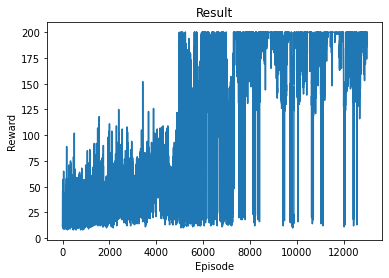

In [ ]:
def plot_reward(r):
    plt.figure(2)
    plt.clf()
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(r)

plot_reward(reward_list)

In [ ]:
env = wrap_env(gym.make('CartPole-v0'))

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
model_validate = DQN_Network(layer_size_list=[input_dim, 64, output_dim], lr=1e-3)
model_validate.load_pretrained_model("cartpole-dqn.pth")

reward_arr = []
for i in tqdm(range(300)):
    obs, done, rew = env.reset(), False, 0
    env.render()
    while not done:
        A = get_action(model_validate, obs, env.action_space.n, epsilon=0)
        #print(A)
        obs, reward, done, info = env.step(A.item())
        rew += reward
        # sleep(0.01)

    reward_arr.append(rew)
print("average reward per episode :", sum(reward_arr) / len(reward_arr))
env.close()
show_video()

100%|██████████| 300/300 [00:18<00:00, 16.06it/s]

average reward per episode : 200.0
